In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *


from BaselinePrerocess import baseline_process
from baselines.transformer import transformer_encoder

2023-07-22 00:23:41.948551: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 00:23:43.461204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Preprocess

In [3]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9

In [4]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


In [6]:
train_X_mask = train_X_mask[:, :n_hours, :]
val_X_mask = val_X_mask[:, :n_hours, :]
test_X_mask = test_X_mask[:, :n_hours, :]

In [7]:
print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

(77069, 72, 16) (9634, 72, 16) (19268, 72, 16) (77069, 96) (9634, 96) (19268, 96)


### Model

In [8]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
headsize = 64*2
ff_dim = 64
num_transformer_blocks = 1
num_heads = 1
mlp_units = 32
dropout = 0.4
mlp_dropout = 0.3
masked_value = 1e-10
learning_rate = 5e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 500
EPOCHS = 3000
BATCH = 512

In [9]:
model = transformer_encoder(input_shape,
                            head_size=headsize, 
                            num_heads=num_heads, 
                            ff_dim=ff_dim, 
                            num_transformer_blocks=num_transformer_blocks, 
                            mlp_units=mlp_units, 
                            dropout=dropout, 
                            mlp_dropout=mlp_dropout,
                            masked_value=masked_value
                           )
model.summary()

2023-07-22 00:24:06.792710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:85:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 16)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 72, 16)               0         ['input_1[0][0]']             
                                                                                                  
 multi_head_attention (Mult  (None, 72, 16)               8592      ['masking[0][0]',             
 iHeadAttention)                                                     'masking[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 72, 16)               0         ['multi_head_attention[0][

In [10]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('saved_models/transformer_encoder_gate_pump_nofuture.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit([train_X_mask], train_ws_y,
          validation_data=([test_X_mask], test_ws_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/3000


2023-07-22 00:24:18.075774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-22 00:24:19.096697: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbd96c2e0e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-22 00:24:19.096739: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-07-22 00:24:19.106696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-22 00:24:19.502996: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_mae improved from inf to 0.14111, saving model to saved_models/transformer_encoder_gate_pump_nofuture.h5
151/151 - 12s - loss: 0.3925 - mae: 0.4442 - val_loss: 0.0327 - val_mae: 0.1411 - 12s/epoch - 80ms/step
Epoch 2/3000


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_mae improved from 0.14111 to 0.08137, saving model to saved_models/transformer_encoder_gate_pump_nofuture.h5
151/151 - 2s - loss: 0.0594 - mae: 0.1909 - val_loss: 0.0109 - val_mae: 0.0814 - 2s/epoch - 16ms/step
Epoch 3/3000

Epoch 3: val_mae improved from 0.08137 to 0.06098, saving model to saved_models/transformer_encoder_gate_pump_nofuture.h5
151/151 - 2s - loss: 0.0301 - mae: 0.1359 - val_loss: 0.0061 - val_mae: 0.0610 - 2s/epoch - 16ms/step
Epoch 4/3000

Epoch 4: val_mae improved from 0.06098 to 0.05726, saving model to saved_models/transformer_encoder_gate_pump_nofuture.h5
151/151 - 2s - loss: 0.0195 - mae: 0.1092 - val_loss: 0.0053 - val_mae: 0.0573 - 2s/epoch - 16ms/step
Epoch 5/3000

Epoch 5: val_mae improved from 0.05726 to 0.05431, saving model to saved_models/transformer_encoder_gate_pump_nofuture.h5
151/151 - 2s - loss: 0.0142 - mae: 0.0930 - val_loss: 0.0047 - val_mae: 0.0543 - 2s/epoch - 16ms/step
Epoch 6/3000

Epoch 6: val_mae improved from 0.05431 to 0.051


Epoch 40: val_mae did not improve from 0.03362
151/151 - 2s - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0020 - val_mae: 0.0351 - 2s/epoch - 15ms/step
Epoch 41/3000

Epoch 41: val_mae did not improve from 0.03362
151/151 - 2s - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0019 - val_mae: 0.0342 - 2s/epoch - 15ms/step
Epoch 42/3000

Epoch 42: val_mae improved from 0.03362 to 0.03341, saving model to saved_models/transformer_encoder_gate_pump_nofuture.h5
151/151 - 2s - loss: 0.0012 - mae: 0.0258 - val_loss: 0.0018 - val_mae: 0.0334 - 2s/epoch - 16ms/step
Epoch 43/3000

Epoch 43: val_mae improved from 0.03341 to 0.03315, saving model to saved_models/transformer_encoder_gate_pump_nofuture.h5
151/151 - 2s - loss: 0.0012 - mae: 0.0256 - val_loss: 0.0018 - val_mae: 0.0331 - 2s/epoch - 16ms/step
Epoch 44/3000

Epoch 44: val_mae did not improve from 0.03315
151/151 - 2s - loss: 0.0011 - mae: 0.0252 - val_loss: 0.0019 - val_mae: 0.0339 - 2s/epoch - 15ms/step
Epoch 45/3000

Epoch 45: val_mae did not i

Epoch 86/3000

Epoch 86: val_mae did not improve from 0.02890
151/151 - 2s - loss: 8.5215e-04 - mae: 0.0216 - val_loss: 0.0017 - val_mae: 0.0323 - 2s/epoch - 15ms/step
Epoch 87/3000

Epoch 87: val_mae did not improve from 0.02890
151/151 - 2s - loss: 8.4494e-04 - mae: 0.0215 - val_loss: 0.0017 - val_mae: 0.0321 - 2s/epoch - 16ms/step
Epoch 88/3000

Epoch 88: val_mae did not improve from 0.02890
151/151 - 2s - loss: 8.5074e-04 - mae: 0.0216 - val_loss: 0.0015 - val_mae: 0.0302 - 2s/epoch - 15ms/step
Epoch 89/3000

Epoch 89: val_mae did not improve from 0.02890
151/151 - 2s - loss: 8.3714e-04 - mae: 0.0214 - val_loss: 0.0015 - val_mae: 0.0304 - 2s/epoch - 15ms/step
Epoch 90/3000

Epoch 90: val_mae did not improve from 0.02890
151/151 - 2s - loss: 8.2905e-04 - mae: 0.0213 - val_loss: 0.0016 - val_mae: 0.0308 - 2s/epoch - 16ms/step
Epoch 91/3000

Epoch 91: val_mae did not improve from 0.02890
151/151 - 2s - loss: 8.2347e-04 - mae: 0.0212 - val_loss: 0.0017 - val_mae: 0.0324 - 2s/epoch - 15

Epoch 131/3000

Epoch 131: val_mae did not improve from 0.02542
151/151 - 2s - loss: 7.1621e-04 - mae: 0.0197 - val_loss: 0.0012 - val_mae: 0.0262 - 2s/epoch - 15ms/step
Epoch 132/3000

Epoch 132: val_mae did not improve from 0.02542
151/151 - 2s - loss: 7.1394e-04 - mae: 0.0197 - val_loss: 0.0012 - val_mae: 0.0259 - 2s/epoch - 15ms/step
Epoch 133/3000

Epoch 133: val_mae did not improve from 0.02542
151/151 - 2s - loss: 7.1425e-04 - mae: 0.0197 - val_loss: 0.0012 - val_mae: 0.0262 - 2s/epoch - 15ms/step
Epoch 134/3000

Epoch 134: val_mae did not improve from 0.02542
151/151 - 2s - loss: 7.1865e-04 - mae: 0.0197 - val_loss: 0.0012 - val_mae: 0.0266 - 2s/epoch - 15ms/step
Epoch 135/3000

Epoch 135: val_mae did not improve from 0.02542
151/151 - 2s - loss: 7.1308e-04 - mae: 0.0197 - val_loss: 0.0011 - val_mae: 0.0255 - 2s/epoch - 15ms/step
Epoch 136/3000

Epoch 136: val_mae did not improve from 0.02542
151/151 - 2s - loss: 7.1210e-04 - mae: 0.0196 - val_loss: 0.0011 - val_mae: 0.0258 - 2

Epoch 179/3000

Epoch 179: val_mae did not improve from 0.02530
151/151 - 2s - loss: 6.9202e-04 - mae: 0.0194 - val_loss: 0.0013 - val_mae: 0.0271 - 2s/epoch - 15ms/step
Epoch 180/3000

Epoch 180: val_mae did not improve from 0.02530
151/151 - 2s - loss: 6.9178e-04 - mae: 0.0193 - val_loss: 0.0012 - val_mae: 0.0256 - 2s/epoch - 15ms/step
Epoch 181/3000

Epoch 181: val_mae did not improve from 0.02530
151/151 - 2s - loss: 6.8926e-04 - mae: 0.0193 - val_loss: 0.0012 - val_mae: 0.0258 - 2s/epoch - 15ms/step
Epoch 182/3000

Epoch 182: val_mae did not improve from 0.02530
151/151 - 2s - loss: 6.9333e-04 - mae: 0.0194 - val_loss: 0.0012 - val_mae: 0.0258 - 2s/epoch - 16ms/step
Epoch 183/3000

Epoch 183: val_mae did not improve from 0.02530
151/151 - 2s - loss: 6.8822e-04 - mae: 0.0193 - val_loss: 0.0012 - val_mae: 0.0256 - 2s/epoch - 15ms/step
Epoch 184/3000

Epoch 184: val_mae did not improve from 0.02530
151/151 - 2s - loss: 6.9293e-04 - mae: 0.0194 - val_loss: 0.0012 - val_mae: 0.0259 - 2

Epoch 226/3000

Epoch 226: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.8499e-04 - mae: 0.0192 - val_loss: 0.0013 - val_mae: 0.0260 - 2s/epoch - 15ms/step
Epoch 227/3000

Epoch 227: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.8086e-04 - mae: 0.0192 - val_loss: 0.0012 - val_mae: 0.0259 - 2s/epoch - 15ms/step
Epoch 228/3000

Epoch 228: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.8028e-04 - mae: 0.0192 - val_loss: 0.0013 - val_mae: 0.0263 - 2s/epoch - 15ms/step
Epoch 229/3000

Epoch 229: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7798e-04 - mae: 0.0191 - val_loss: 0.0012 - val_mae: 0.0258 - 2s/epoch - 15ms/step
Epoch 230/3000

Epoch 230: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.8461e-04 - mae: 0.0192 - val_loss: 0.0012 - val_mae: 0.0254 - 2s/epoch - 15ms/step
Epoch 231/3000

Epoch 231: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7971e-04 - mae: 0.0192 - val_loss: 0.0012 - val_mae: 0.0257 - 2

151/151 - 2s - loss: 6.7480e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0270 - 2s/epoch - 15ms/step
Epoch 275/3000

Epoch 275: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7607e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0263 - 2s/epoch - 15ms/step
Epoch 276/3000

Epoch 276: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7605e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0264 - 2s/epoch - 15ms/step
Epoch 277/3000

Epoch 277: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7420e-04 - mae: 0.0191 - val_loss: 0.0012 - val_mae: 0.0259 - 2s/epoch - 15ms/step
Epoch 278/3000

Epoch 278: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7258e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0271 - 2s/epoch - 15ms/step
Epoch 279/3000

Epoch 279: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7495e-04 - mae: 0.0191 - val_loss: 0.0012 - val_mae: 0.0258 - 2s/epoch - 15ms/step
Epoch 280/3000

Epoch 280: val_mae did not i

Epoch 323/3000

Epoch 323: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7032e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0267 - 2s/epoch - 15ms/step
Epoch 324/3000

Epoch 324: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6754e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0264 - 2s/epoch - 15ms/step
Epoch 325/3000

Epoch 325: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6865e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0267 - 2s/epoch - 15ms/step
Epoch 326/3000

Epoch 326: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6987e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0266 - 2s/epoch - 15ms/step
Epoch 327/3000

Epoch 327: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7012e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0274 - 2s/epoch - 15ms/step
Epoch 328/3000

Epoch 328: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.7069e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0271 - 2

151/151 - 2s - loss: 6.6471e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0262 - 2s/epoch - 15ms/step
Epoch 372/3000

Epoch 372: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6496e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0264 - 2s/epoch - 15ms/step
Epoch 373/3000

Epoch 373: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6550e-04 - mae: 0.0190 - val_loss: 0.0014 - val_mae: 0.0278 - 2s/epoch - 15ms/step
Epoch 374/3000

Epoch 374: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6644e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0266 - 2s/epoch - 15ms/step
Epoch 375/3000

Epoch 375: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6465e-04 - mae: 0.0190 - val_loss: 0.0015 - val_mae: 0.0278 - 2s/epoch - 15ms/step
Epoch 376/3000

Epoch 376: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6395e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mae: 0.0268 - 2s/epoch - 15ms/step
Epoch 377/3000

Epoch 377: val_mae did not i

Epoch 420/3000

Epoch 420: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6178e-04 - mae: 0.0189 - val_loss: 0.0013 - val_mae: 0.0267 - 2s/epoch - 15ms/step
Epoch 421/3000

Epoch 421: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6084e-04 - mae: 0.0189 - val_loss: 0.0015 - val_mae: 0.0285 - 2s/epoch - 15ms/step
Epoch 422/3000

Epoch 422: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6400e-04 - mae: 0.0190 - val_loss: 0.0014 - val_mae: 0.0279 - 2s/epoch - 15ms/step
Epoch 423/3000

Epoch 423: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6442e-04 - mae: 0.0190 - val_loss: 0.0014 - val_mae: 0.0281 - 2s/epoch - 15ms/step
Epoch 424/3000

Epoch 424: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6007e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0277 - 2s/epoch - 15ms/step
Epoch 425/3000

Epoch 425: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.6098e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0275 - 2

151/151 - 2s - loss: 6.6058e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0273 - 2s/epoch - 15ms/step
Epoch 469/3000

Epoch 469: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5978e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0277 - 2s/epoch - 15ms/step
Epoch 470/3000

Epoch 470: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5738e-04 - mae: 0.0189 - val_loss: 0.0013 - val_mae: 0.0271 - 2s/epoch - 15ms/step
Epoch 471/3000

Epoch 471: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5829e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0279 - 2s/epoch - 15ms/step
Epoch 472/3000

Epoch 472: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5943e-04 - mae: 0.0189 - val_loss: 0.0013 - val_mae: 0.0270 - 2s/epoch - 15ms/step
Epoch 473/3000

Epoch 473: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5766e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0274 - 2s/epoch - 15ms/step
Epoch 474/3000

Epoch 474: val_mae did not i

Epoch 517/3000

Epoch 517: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5822e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0281 - 2s/epoch - 15ms/step
Epoch 518/3000

Epoch 518: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5651e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0274 - 2s/epoch - 15ms/step
Epoch 519/3000

Epoch 519: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5620e-04 - mae: 0.0189 - val_loss: 0.0015 - val_mae: 0.0283 - 2s/epoch - 15ms/step
Epoch 520/3000

Epoch 520: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5695e-04 - mae: 0.0189 - val_loss: 0.0013 - val_mae: 0.0272 - 2s/epoch - 15ms/step
Epoch 521/3000

Epoch 521: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5376e-04 - mae: 0.0188 - val_loss: 0.0015 - val_mae: 0.0288 - 2s/epoch - 15ms/step
Epoch 522/3000

Epoch 522: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5717e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0283 - 2

151/151 - 2s - loss: 6.5314e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0277 - 2s/epoch - 15ms/step
Epoch 566/3000

Epoch 566: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5479e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0279 - 2s/epoch - 15ms/step
Epoch 567/3000

Epoch 567: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5334e-04 - mae: 0.0188 - val_loss: 0.0015 - val_mae: 0.0283 - 2s/epoch - 15ms/step
Epoch 568/3000

Epoch 568: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5443e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0281 - 2s/epoch - 15ms/step
Epoch 569/3000

Epoch 569: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5403e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0294 - 2s/epoch - 15ms/step
Epoch 570/3000

Epoch 570: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5537e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0294 - 2s/epoch - 15ms/step
Epoch 571/3000

Epoch 571: val_mae did not i

Epoch 614/3000

Epoch 614: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.4913e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0283 - 2s/epoch - 15ms/step
Epoch 615/3000

Epoch 615: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5116e-04 - mae: 0.0188 - val_loss: 0.0015 - val_mae: 0.0293 - 2s/epoch - 15ms/step
Epoch 616/3000

Epoch 616: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5350e-04 - mae: 0.0188 - val_loss: 0.0013 - val_mae: 0.0275 - 2s/epoch - 15ms/step
Epoch 617/3000

Epoch 617: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5087e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0277 - 2s/epoch - 15ms/step
Epoch 618/3000

Epoch 618: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5291e-04 - mae: 0.0188 - val_loss: 0.0013 - val_mae: 0.0273 - 2s/epoch - 15ms/step
Epoch 619/3000

Epoch 619: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.5026e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0279 - 2

151/151 - 2s - loss: 6.4824e-04 - mae: 0.0188 - val_loss: 0.0013 - val_mae: 0.0271 - 2s/epoch - 16ms/step
Epoch 663/3000

Epoch 663: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.4868e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0274 - 2s/epoch - 16ms/step
Epoch 664/3000

Epoch 664: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.4868e-04 - mae: 0.0188 - val_loss: 0.0013 - val_mae: 0.0273 - 2s/epoch - 16ms/step
Epoch 665/3000

Epoch 665: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.4986e-04 - mae: 0.0188 - val_loss: 0.0015 - val_mae: 0.0284 - 2s/epoch - 15ms/step
Epoch 666/3000

Epoch 666: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.4919e-04 - mae: 0.0188 - val_loss: 0.0014 - val_mae: 0.0282 - 2s/epoch - 15ms/step
Epoch 667/3000

Epoch 667: val_mae did not improve from 0.02509
151/151 - 2s - loss: 6.4609e-04 - mae: 0.0187 - val_loss: 0.0014 - val_mae: 0.0279 - 2s/epoch - 15ms/step
Epoch 668/3000

Epoch 668: val_mae did not i

### Performance

In [11]:
saved_model = load_model('saved_models/transformer_encoder_gate_pump_nofuture.h5')

yhat = saved_model.predict(test_X_mask)

inv_yhat = ws_scaler.inverse_transform(yhat)
inv_y = ws_scaler.inverse_transform(test_ws_y)

print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_y, inv_yhat))))))

603/603 [==============================] - 2s 2ms/step
inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)
MAE = 0.1323
RMSE = 0.175


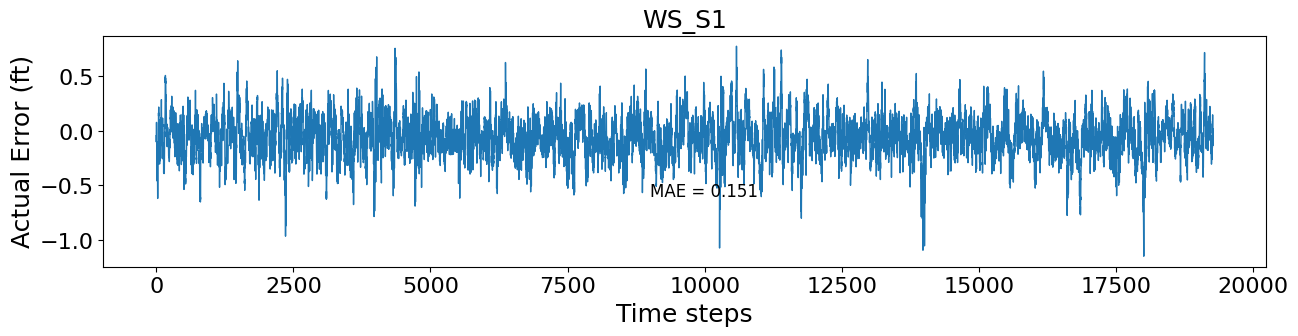

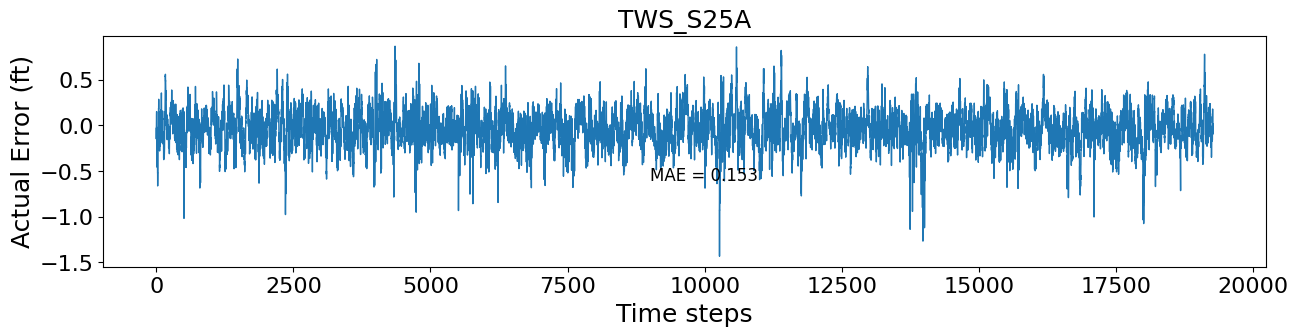

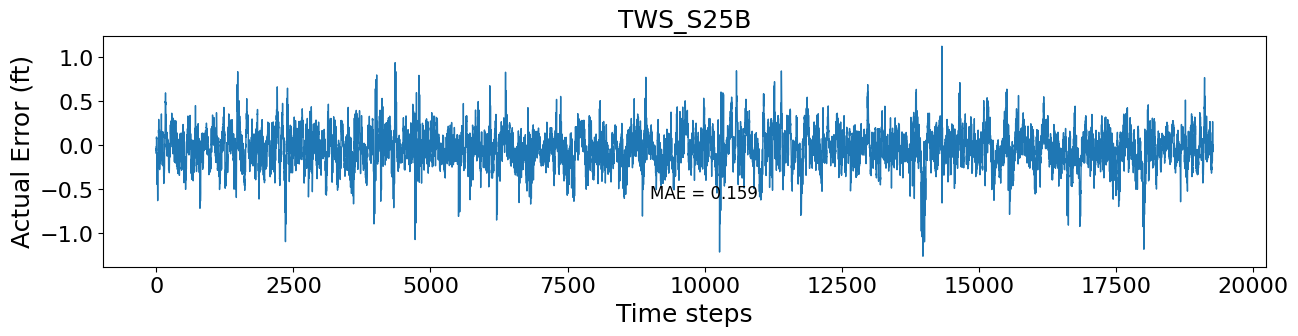

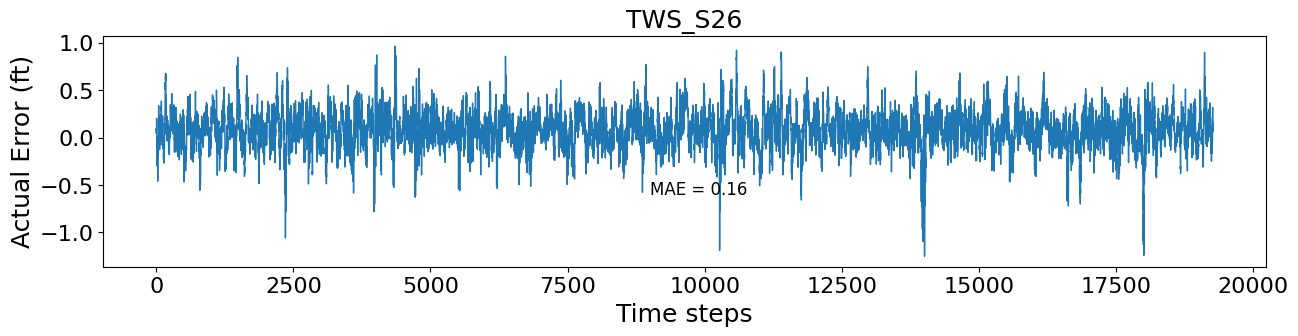

In [12]:
wss = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
inv_yhat_reshape = inv_yhat.reshape((-1, 24, 4))
inv_y_reshape = inv_y.reshape((-1, 24, 4))

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    plt.plot(error[:, -1, i], linewidth=1)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Time steps', fontsize=18)
    plt.ylabel('Actual Error (ft)', fontsize=18)
    plt.title('{}'.format(wss[i]), fontsize=18)
    plt.text(9000, -0.6, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error[:, -1, i]))/len(error)))), fontsize=12)
    plt.show()

In [13]:
up_thre = 0.5
low_thre = -0.5

for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre) + np.sum(error[:, -1, i] < low_thre))

(19268,)
324
(19268,)
365
(19268,)
511
(19268,)
436


In [14]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] > up_thre))

(19268,)
74
(19268,)
109
(19268,)
165
(19268,)
312


In [15]:
for i in range(len(wss)):
    plt.rcParams["figure.figsize"] = (15, 3)
    error = inv_yhat_reshape - inv_y_reshape
    error_24h = error[:, -1, i]
    print(error_24h.shape)
    print(np.sum(error[:, -1, i] < low_thre))

(19268,)
250
(19268,)
256
(19268,)
346
(19268,)
124
